## Libraries

In [27]:
import time
import h5py
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
np.random.seed(1)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Intialize parameters

<a name='3-2'></a>

when you compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{3}  $$


In [28]:
def initialize_parameters_deep(layer_dims):

    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # num.layers

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## Forward Propagation Module

consist of :
- linear_forward
- sigmoid
- relu
- linear_activation_forward
- L_model_forward

<a name='4-1'></a>
### linear_forward 

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

In [29]:
def linear_forward(A, W, b):

    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

### sigmoid: 
$\sigma(Z) =\frac{1}{ 1 + e^{-(W A + b)}}$. returns:<br/>
   - activation value "`a`"<br/>
   - "`cache`" that contains "`Z`"<br/>

In [30]:
def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache


### ReLU:
$A = RELU(Z) = max(0, Z)$. <br/>returns:<br/> 

- the activation value "`A`" 
- "`cache`" that contains "`Z`"

In [31]:
def relu(Z):  
    
    A = np.maximum(0,Z)   
    cache = Z 
    
    return A, cache


### linear_activation_forward

Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu().

In [32]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

<a name='4-3'></a>
### L_model_forward 

we will need a function that : 
- replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times.
- follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">

In [33]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2 # num of layers
    
    for l in range(1, L):
        A_prev = A 

        A, cache = linear_activation_forward(A_prev,parameters['W'+ str(l)], parameters['b'+ str(l)], "relu")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A,parameters['W'+ str(L)] , parameters['b'+ str(L)], "sigmoid")
    caches.append(cache)
    
    
    assert(AL.shape == (1,X.shape[1])) ##
          
    return AL, caches

## Cost Computation

We need to compute the cost, to check if your model is actually learning.


we will compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [34]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)  
    assert(cost.shape == ())
    
    return cost

## Backward Propagation Module

backpropagation calculate the derivative of the loss function with respect to the parameters. 

<b>consist of :</b>
- linear_backward
- relu_backward
- sigmoid_backward 
- linear_activation_backward
- L_model_backward </p>
 
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">



<a name='6-1'></a>
### linear_backward

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$

In [35]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW =  np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis =1, keepdims = True) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

### relu_backward:
Implementation of the backward propagation for relu unit.


In [36]:
def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0
    
    return dZ

### sigmoid_backward:
Implementation of the backward propagation for sigmoid unit.

In [37]:
def sigmoid_backward(dA, cache):
   
    Z = cache    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

### linear_activation_backward

a function that merges: `linear_backward` and `linear_activation_backward`. 


If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute

$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$  


In [38]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache  
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)      
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### 6.3 - L-Model Backward 


when implemented the `L_model_forward` function, at each iteration, you stored a cache which contains (X,W,b, and z).<br/>
In the back propagation module, you'll use those variables to compute the gradients.<br/> Therefore, in the `L_model_backward` function, you'll iterate through all the hidden layers backward, starting from layer $L$. On each step, you will use the cached values for layer $l$ to backpropagate through layer $l$.

<img src="images/mn_backward.png" style="width:450px;height:300px;">

the output is: 
$A^{[L]} = \sigma(Z^{[L]})$. the code needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.


In [39]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # num of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1] 
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] =  dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp   

    return grads

## Update Prameters

In this section, you'll update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. 

After computing the updated parameters, store them in the parameters dictionary. 

In [40]:
def update_parameters(params, grads, learning_rate):

    parameters = params.copy()
    L = len(parameters) // 2

    for l in range(L):        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db"+str(l+1)]     
        
    return parameters

# -----------------------------------------------------------------------------------------------------------------

In [41]:
def load_data():
    
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # trainset features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # trainset labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # testset features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # testset labels

    classes = np.array(test_dataset["list_classes"][:]) # list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [42]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


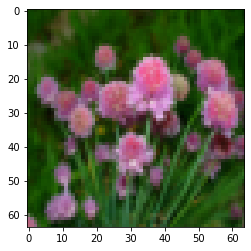

In [43]:
index = 21
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [44]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [45]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [46]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [47]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = [] 
    
    parameters = initialize_parameters_deep(layers_dims)    
    
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)   
        cost = compute_cost(AL, Y)
                
        grads = L_model_backward(AL, Y, caches)
               
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [48]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822914
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366111
Cost after iteration 500: 0.54013766345478
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.3691258524959279
Cost after iteration 900: 0.39174697434805344
Cost after iteration 1000: 0.31518698886006163
Cost after iteration 1100: 0.2726998441789384
Cost after iteration 1200: 0.23741853400268134
Cost after iteration 1300: 0.19960120532208647
Cost after iteration 1400: 0.18926300388463302
Cost after iteration 1500: 0.16118854665827753
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.12974017549190123
Cost after iteration 1900: 0.12122535068005212
Cost after iteration 2000: 0.11382060668633712
Cost after iteration 2100: 0.1078392

In [52]:
def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)
   
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(100 * np.sum((p == y)/m)))   
    return p

In [53]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 98.5645933014354


In [54]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 80.0


## Try yourself

Accuracy: 100.0
y = 1.0, your L-layer model predicts a "cat" picture.


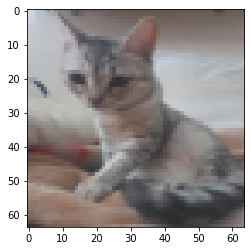

In [55]:
my_image = "mycat.jpeg" #<-----put address here
my_label_y = [1] 


fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)

print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")